# Lecture 11 Supplemental Notebook

Data 100, Fall 2021

Suraj Rampure, with updates by Fernando Pérez.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid', font_scale = 1.5,
            rc={'figure.figsize':(7,5)})

#plt.rc('figure', dpi=100, figsize=(7, 5))
#plt.rc('font', size=12)
rng = np.random.default_rng()

# Scale

In [2]:
ppdf = pd.DataFrame(dict(Cancer=[2007371, 935573], Abortion=[289750, 327000]), 
                    index=pd.Series([2006, 2013], 
                    name="Year"))
ppdf

,Cancer,Abortion
Year,,
2006,2007371,289750
2013,935573,327000


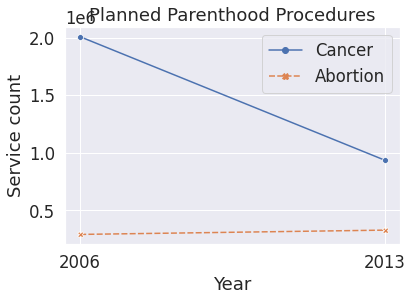

In [3]:
ax = sns.lineplot(data=ppdf, markers=True)
ax.set_title("Planned Parenthood Procedures")
ax.set_xticks([2006, 2013])
ax.set_ylabel("Service count");

Let's now compute the relative change between the two years...

In [4]:
rel_change = 100*(ppdf.loc[2013] - ppdf.loc[2006])/ppdf.loc[2006]
rel_change.name = "Percent Change"
rel_change

Cancer     -53.39312
Abortion    12.85591
Name: Percent Change, dtype: float64

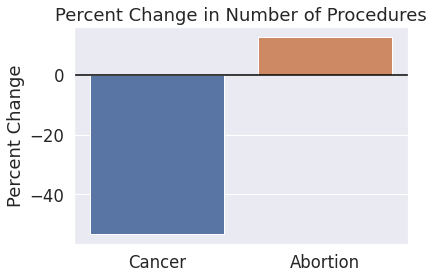

In [7]:
ax = sns.barplot(x=rel_change.index, y=rel_change)
ax.axhline(0, color='black')
ax.set_title("Percent Change in Number of Procedures");

## Current Population Survey

In [8]:
cps = pd.read_csv("edInc2.csv")
cps

,educ,gender,income
0,1,Men,517
1,1,Women,409
2,2,Men,751
3,2,Women,578
4,3,Men,872
5,3,Women,661
6,4,Men,1249
7,4,Women,965
8,5,Men,1385
9,5,Women,1049


In [9]:
cps = cps.replace({'educ':{1:"<HS", 2:"HS", 3:"<BA", 4:"BA", 5:">BA"}})
cps.columns = ['Education', 'Gender', 'Income']
cps

,Education,Gender,Income
0,<HS,Men,517
1,<HS,Women,409
2,HS,Men,751
3,HS,Women,578
4,<BA,Men,872
5,<BA,Women,661
6,BA,Men,1249
7,BA,Women,965
8,>BA,Men,1385
9,>BA,Women,1049


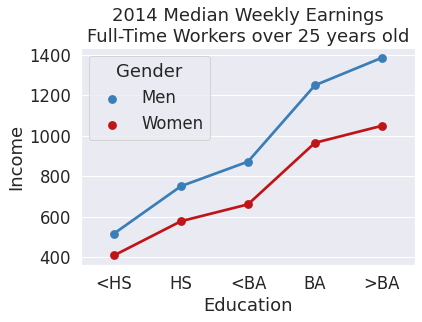

In [10]:
# Let's pick our colors specifically using color_palette()
blue_red = ["#397eb7", "#bf1518"]
with sns.color_palette(sns.color_palette(blue_red)):
    ax = sns.pointplot(data=cps, x = "Education", y = "Income", hue = "Gender")

ax.set_title("2014 Median Weekly Earnings\nFull-Time Workers over 25 years old");

Now, let's compute the income gap as a relative quantity between men and women. Recall that the structure of the dataframe is as follows:

In [11]:
cps.head()

,Education,Gender,Income
0,<HS,Men,517
1,<HS,Women,409
2,HS,Men,751
3,HS,Women,578
4,<BA,Men,872


This calls for using `groupby` by Gender, so that we can separate the data for both genders, and then compute the ratio:

In [12]:
cg = cps.set_index("Education").groupby("Gender")
men = cg.get_group("Men").drop("Gender", "columns")
women = cg.get_group("Women").drop("Gender", "columns")
display(men, women)

,Income
Education,
<HS,517
HS,751
<BA,872
BA,1249
>BA,1385


,Income
Education,
<HS,409
HS,578
<BA,661
BA,965
>BA,1049


In [13]:
mfratio = men/women
mfratio.columns = ["Income Ratio (M/F)"]
mfratio

,Income Ratio (M/F)
Education,
<HS,1.264059
HS,1.299308
<BA,1.319213
BA,1.294301
>BA,1.320305


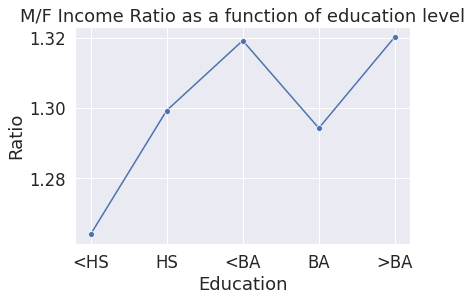

In [14]:
ax = sns.lineplot(data=mfratio, markers=True, legend=False);
ax.set_ylabel("Ratio")
ax.set_title("M/F Income Ratio as a function of education level");

Let's now compute the alternate ratio, F/M instead:

In [16]:
fmratio = women/men
fmratio.columns = ["Income Ratio (F/M)"]
fmratio

,Income Ratio (F/M)
Education,
<HS,0.791103
HS,0.769640
<BA,0.758028
BA,0.772618
>BA,0.757401


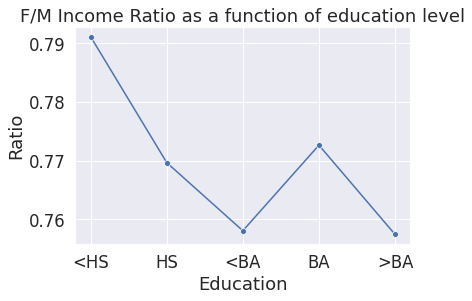

In [17]:
ax = sns.lineplot(data=fmratio, markers=True, legend=False);
ax.set_ylabel("Ratio")
ax.set_title("F/M Income Ratio as a function of education level");

# Overplotting

In [18]:
df = pd.read_csv('baby.csv')

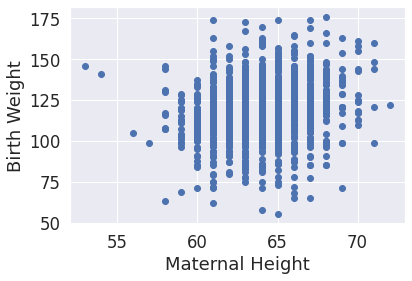

In [19]:
plt.scatter(df['Maternal Height'], df['Birth Weight']);
plt.xlabel('Maternal Height')
plt.ylabel('Birth Weight');

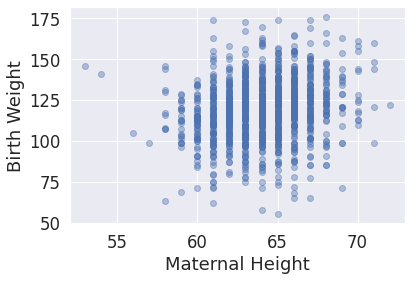

In [20]:
plt.scatter(df['Maternal Height'], df['Birth Weight'], alpha = 0.4);
plt.xlabel('Maternal Height')
plt.ylabel('Birth Weight');

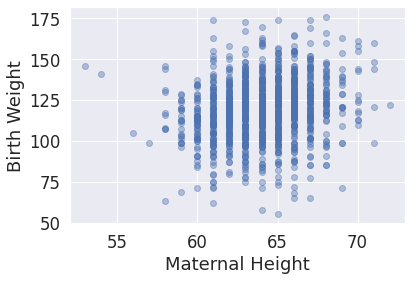

In [21]:
plt.scatter(data=df, x='Maternal Height', y='Birth Weight', alpha = 0.4);
plt.xlabel('Maternal Height')
plt.ylabel('Birth Weight');

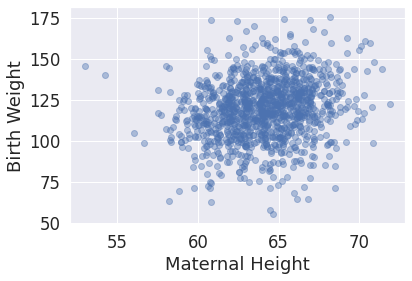

In [22]:
r1, r2 = rng.normal(size=(2, len(df)))/3

plt.scatter(df['Maternal Height'] + r1, df['Birth Weight'] + r2, alpha = 0.4);
plt.xlabel('Maternal Height')
plt.ylabel('Birth Weight');

# Kernel Density Estimates

In [23]:
points = [2.2, 2.8, 3.7, 5.3, 5.7]

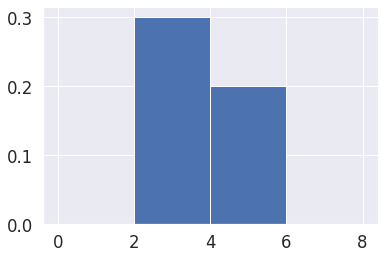

In [24]:
plt.hist(points, bins=range(0, 10, 2), ec='w', density=True);

Let's define some **kernels**. We will explain these formulas momentarily. We'll also define some helper functions for visualization purposes.

In [25]:
def gaussian(x, z, a):
    # Gaussian kernel
    return (1/np.sqrt(2*np.pi*a**2)) * np.exp((-(x - z)**2 / (2 * a**2)))

def boxcar_basic(x, z, a):
    # Boxcar kernel
    if np.abs(x - z) <= a/2:
        return 1/a
    return 0

def boxcar(x, z, a):
    # Boxcar kernel
    cond = np.abs(x - z)
    return np.piecewise(x, [cond <= a/2, cond > a/2], [1/a, 0] )

In [26]:
def create_kde(kernel, pts, a):
    # Takes in a kernel, set aof points, and alpha
    # Returns the KDE as a function
    def f(x):
        output = 0
        for pt in pts:
            output += kernel(x, pt, a)
        return output / len(pts) # Normalization factor
    return f

def plot_kde(kernel, pts, a):
    # Calls create_kde and plots the corresponding KDE
    f = create_kde(kernel, pts, a)
    x = np.linspace(min(pts) - 5, max(pts) + 5, 1000)
    y = [f(xi) for xi in x]
    plt.plot(x, y);
    
def plot_separate_kernels(kernel, pts, a, norm=False):
    # Plots individual kernels, which are then summed to create the KDE
    x = np.linspace(min(pts) - 5, max(pts) + 5, 1000)
    for pt in pts:
        y = kernel(x, pt, a)
        if norm:
            y /= len(pts)
        plt.plot(x, y)
    
    plt.show();

Here are our five points.

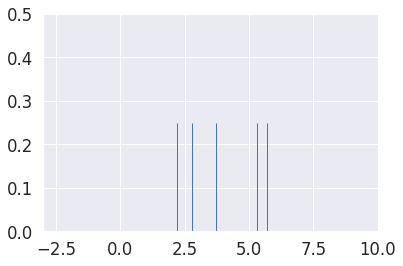

In [27]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
sns.rugplot(points, height = 0.5);

### Step 1: Place a kernel at each point

We'll start with the Gaussian kernel.

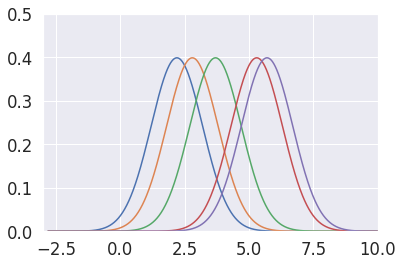

In [28]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plot_separate_kernels(gaussian, points, a = 1);

### Step 2: Normalize kernels so that total area is 1

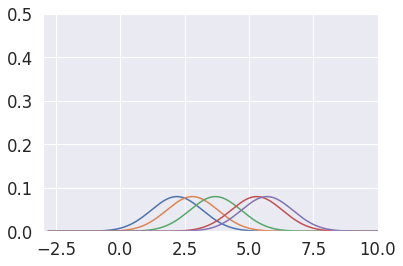

In [29]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plot_separate_kernels(gaussian, points, a = 1, norm = True);

### Step 3: Sum all kernels together

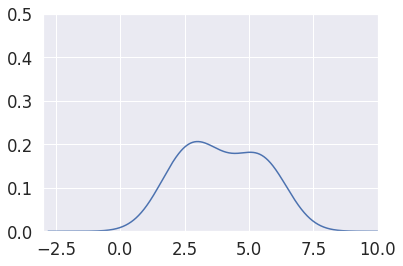

In [31]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plot_kde(gaussian, points, a = 1)

This looks identical to the smooth curve that `sns.distplot` gives us (when we set the appropriate parameter):

/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/frank/miniconda3/envs/data100/lib/python3.6/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


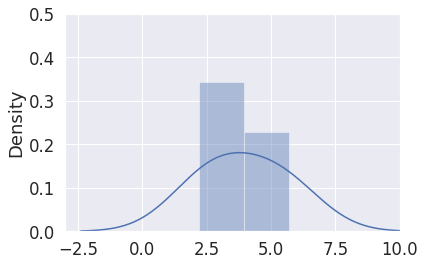

In [32]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
sns.distplot(points, kde_kws={'bw': 1});

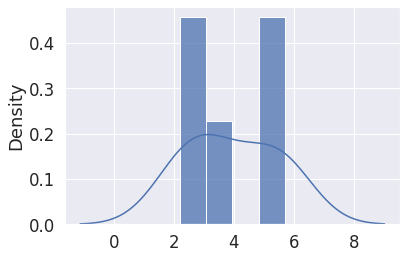

In [33]:
sns.kdeplot(points)
sns.histplot(points, stat='density');

In [ ]:
sns.kdeplot(points, bw_adjust=2)
sns.histplot(points, stat='density');

## Kernels

**Gaussian**

$$K_{\alpha}(x, x_i) = \frac{1}{\sqrt{2 \pi \alpha^2}} e^{-\frac{(x - x_i)^2}{2\alpha^2}}$$


**Boxcar**


$$K_{\alpha}(x, x_i) = \begin {cases}
			\frac{1}{\alpha}, \: \: \: |x - x_i| \leq \frac{\alpha}{2}\\
			0, \: \: \: \text{else}
			\end{cases}$$

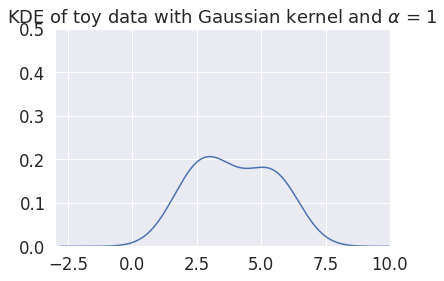

In [34]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plt.title(r'KDE of toy data with Gaussian kernel and $\alpha$ = 1')
plot_kde(gaussian, points, a = 1)

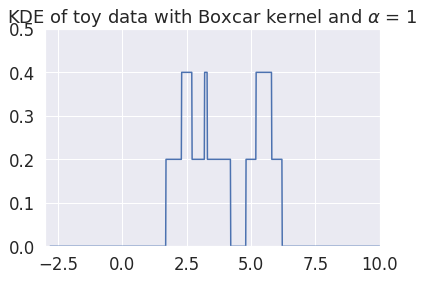

In [35]:
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plt.title(r'KDE of toy data with Boxcar kernel and $\alpha$ = 1')
plot_kde(boxcar, points, a = 1)

## Effect of bandwidth hyperparameter $\alpha$

Let's bring in some (different) toy data.

In [ ]:
tips = sns.load_dataset('tips')

In [ ]:
tips.head()

In [ ]:
vals = tips['total_bill']

In [ ]:
ax = sns.histplot(vals)
sns.rugplot(vals, color='orange', ax=ax);

In [ ]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 0.15)
plt.title(r'KDE of tips with Gaussian kernel and $\alpha$ = 0.1')
plot_kde(gaussian, vals, a = 0.1)

In [ ]:
plt.ylim(0, 0.1)
plt.title(r'KDE of tips with Gaussian kernel and $\alpha$ = 1')
plot_kde(gaussian, vals, a = 1)

In [ ]:
plt.ylim(0, 0.1)
plt.title(r'KDE of tips with Gaussian kernel and $\alpha$ = 2')
plot_kde(gaussian, vals, a = 2)

In [ ]:
plt.ylim(0, 0.1)
plt.title(r'KDE of tips with Gaussian kernel and $\alpha$ = 10')
plot_kde(gaussian, vals, a = 5)

### KDE Formula

$$f_{\alpha}(x) = \sum_{i = 1}^n \frac{1}{n} \cdot K_{\alpha}(x, x_i) =  \frac{1}{n} \sum_{i = 1}^n K_{\alpha}(x, x_i)$$

## CO2 Emissions 

In [38]:
co2 = pd.read_csv("CAITcountryCO2.csv", skiprows = 2,
                  names = ["Country", "Year", "CO2"], encoding = "ISO-8859-1")
co2.tail()

,Country,Year,CO2
30639,Vietnam,2012,173.0497
30640,World,2012,33843.0497
30641,Yemen,2012,20.5386
30642,Zambia,2012,2.7600
30643,Zimbabwe,2012,9.9800


In [39]:
last_year = co2.Year.iloc[-1]
last_year

2012

In [40]:
q = f"Country != 'World' and Country != 'European Union (15)' and Year == {last_year}"
top14_lasty = co2.query(q).sort_values('CO2', ascending=False).iloc[:14]
top14_lasty

,Country,Year,CO2
30490,China,2012,9312.5329
30634,United States,2012,5122.9094
30514,European Union (28),2012,3610.5137
30533,India,2012,2075.1808
30596,Russian Federation,2012,1721.5376
30541,Japan,2012,1249.2135
30521,Germany,2012,773.9585
30547,"Korea, Rep. (South)",2012,617.2418
30535,Iran,2012,593.8195
30485,Canada,2012,543.0242


In [41]:
top14 = co2[co2.Country.isin(top14_lasty.Country) & (co2.Year >= 1950)]
print(len(top14.Country.unique()))
top14.head()

14


,Country,Year,CO2
18822,Brazil,1950,19.6574
18829,Canada,1950,154.1408
18834,China,1950,78.6478
18858,European Union (28),1950,1773.6864
18865,Germany,1950,510.7323


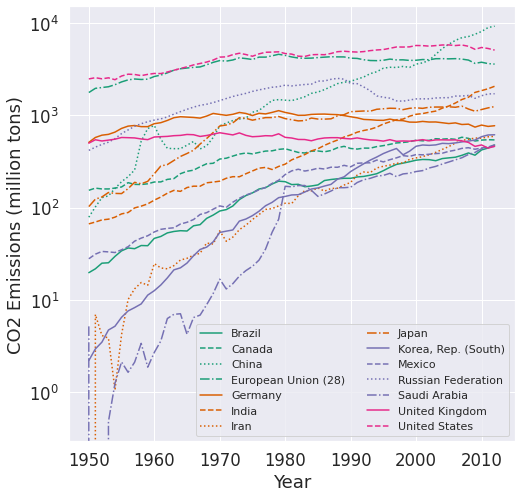

In [42]:
from cycler import cycler

linestyles = ['-', '--', ':', '-.' ]
colors = plt.cm.Dark2.colors
lines_c = cycler('linestyle', linestyles)
color_c = cycler('color', colors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_prop_cycle(color_c * lines_c)

x, y ='Year', 'CO2'
for name, df in top14.groupby('Country'):
    ax.semilogy(df[x], df[y], label=name)

ax.set_xlabel(x)
ax.set_ylabel(f"{y} Emissions (million tons)")
ax.legend(ncol=2, frameon=True, fontsize=11);

## Functional relations

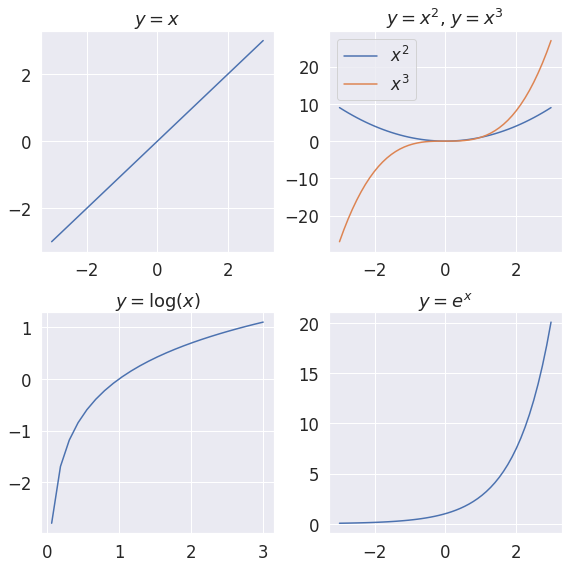

In [43]:
x = np.linspace(-3, 3)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

# x
ax1.plot(x, x)
ax1.set_title('$y=x$')

# powers
ax2.plot(x, x**2, label='$x^2$')
ax2.plot(x, x**3, label='$x^3$')
ax2.legend()
ax2.set_title('$y=x^2$, $y=x^3$')

# log
xpos = x[x>0]  # Log is only defined for positive x
ax3.plot(xpos, np.log(xpos))
ax3.set_title(r'$y=\log(x)$')

# exp
ax4.plot(x, np.exp(x))
ax4.set_title('$y=e^x$');
plt.tight_layout();

# Transformations

<img src='bulge.png' width=350>

## A synthetic example

Let's generate data that follows $y = 2x^3 + \epsilon$, where $\epsilon$ is zero-mean noise. Note that given the functional form of $y$, if we simply draw $\epsilon \sim \mathcal{N}(0,1)$, it will be insignificant for higher values of $x$ (in the range we'll look, $[1..10]$). So we will make $\epsilon \sim x^2\mathcal{N}(0,1)$ so that the noise is present for all values of $x$ and $y$.

In [2]:
x = np.linspace(1, 10, 20)
eps = rng.normal(size=len(x))
y = (2+eps)*x**3
y = 2 * x**3 + x**2*eps

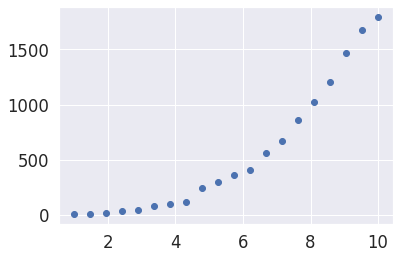

In [3]:
plt.scatter(x, y);

The bulge diagram says to raise $x$ to a power, or to take the log of $y$.

First, let's raise $x$ to a power:

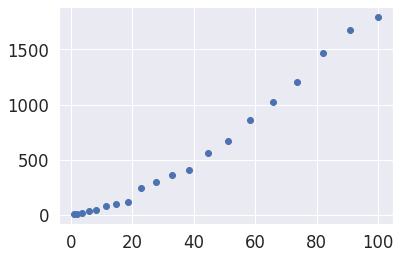

In [4]:
plt.scatter(x**2, y);

We used $x^2$ as the transformation. It's better, but still not linear.
Let's try $x^3$.

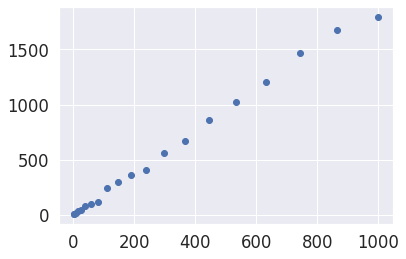

In [5]:
plt.scatter(x**3, y);

That worked well, which makes sense: the original data was cubic in $x$. We can overdo it, too: let's try $x^5$.

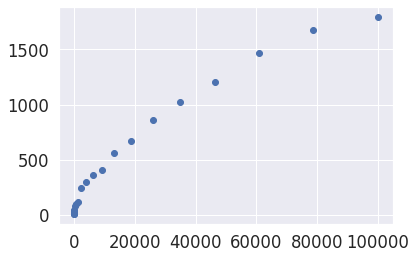

In [6]:
plt.scatter(x**5, y);

Now, the data follows some sort of square root relationship. It's certainly not linear; this goes to show that not all power transformations work the same way, and you'll need some experimentation.

Let's instead try taking the log of y from the original data.

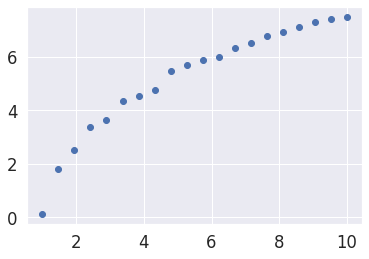

In [7]:
plt.scatter(x, np.log(y));

On it's own, this didn't quite work! Since $y = 2x^3$, $\log(y) = \log(2) + 3\log(x)$.

That means we are essentially plotting `plt.scatter(x, np.log(x))`, which is not linear.

In order for this to be linear, we need to take the log of $x$ as well:

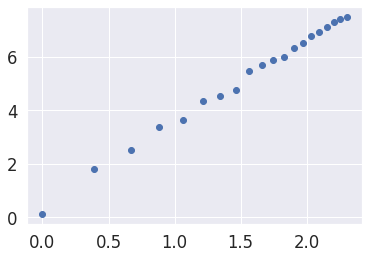

In [8]:
plt.scatter(np.log(x), np.log(y));

The relationship being visualized now is

$$\log(y) = \log(2) + 3 \log(x)$$

## Kepler's third law

Details and data [can be found on Wikipedia](https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion#Third_law_of_Kepler).

In [9]:
planets = pd.read_csv("planets.data", delim_whitespace=True, comment="#")
planets

,planet,mean_dist,period,kepler_ratio
0,Mercury,0.389,87.77,7.64
1,Venus,0.724,224.70,7.52
2,Earth,1.000,365.25,7.50
3,Mars,1.524,686.95,7.50
4,Jupiter,5.200,4332.62,7.49
5,Saturn,9.510,10759.20,7.43


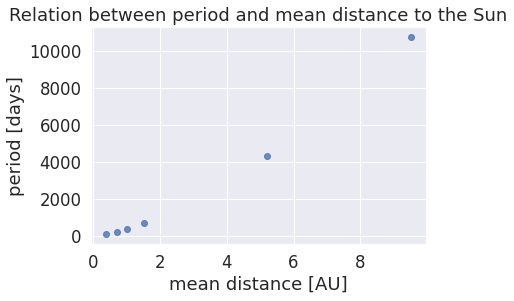

In [10]:
ax = sns.regplot(x='mean_dist', y='period', data=planets, fit_reg=False);
ax.set_title('Relation between period and mean distance to the Sun')
ax.set_xlabel('mean distance [AU]')
ax.set_ylabel('period [days]');

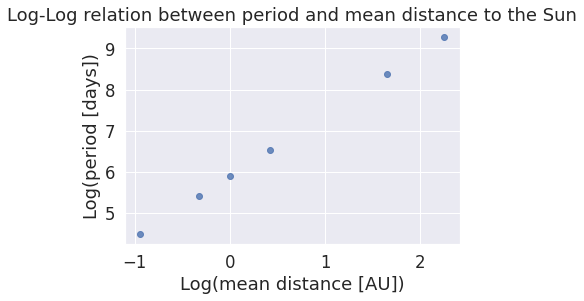

In [15]:
ax = sns.regplot(x=np.log(planets['mean_dist']), y=np.log(planets['period']), fit_reg=False)
ax.set_title('Log-Log relation between period and mean distance to the Sun')
ax.set_xlabel('Log(mean distance [AU])')
ax.set_ylabel('Log(period [days])');

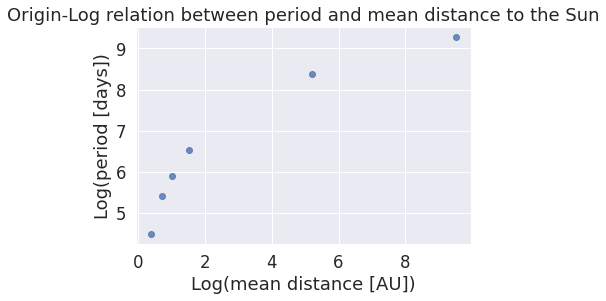

In [14]:
ax = sns.regplot(x=planets['mean_dist'], y=np.log(planets['period']), fit_reg=False)
ax.set_title('Origin-Log relation between period and mean distance to the Sun')
ax.set_xlabel('Log(mean distance [AU])')
ax.set_ylabel('Log(period [days])');

In fact, Kepler's law actually states that:


$$
T^2\propto R^3
$$

For Kepler this was a data-driven phenomenological law, formulated in 1619. It could only be explained dynamically once Newton introduced his law of universal gravitation in 1687.

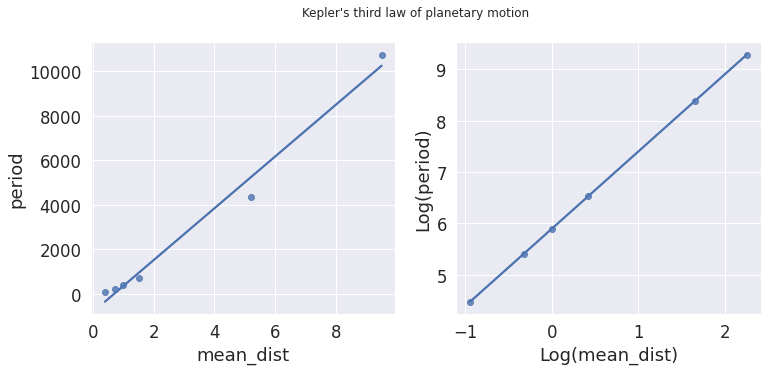

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='mean_dist', y='period', data=planets, ax=ax1, ci=False);

sns.regplot(x=np.log(planets['mean_dist']), y=np.log(planets['period']), ax=ax2);
ax2.set_xlabel('Log(mean_dist)')
ax2.set_ylabel('Log(period)')
ax2.relim()
ax2.autoscale_view()
fig.suptitle("Kepler's third law of planetary motion");